In [4]:
using Plots
using LinearAlgebra
using Parameters

In [141]:
module My

using Parameters 

@with_kw struct PhysicalParam{T} @deftype Float64
    ħc = 197.
    mc² = 938.
    M = ħc^2/2mc²
    
    Z::Int64 = 8
    N::Int64 = 8
    A::Int64 = Z + N
    
    t₀ = -1800
    x₀ = 0.0
    t₃ = 12871
    x₃ = 0.0
    α = 1/3
    
    Emax = 50.0
    lmax::Int64 = 5
    nstates_max::Int64 = 1000
    
    Nr::Int64 = 100
    Δr = 0.1
    rs::T = range(Δr, Nr*Δr, length=Nr)
    
    dv::Vector{Float64} = zeros(Float64, Nr  )
    ev::Vector{Float64} = zeros(Float64, Nr-1)
    
    dψ::Vector{Float64} = zeros(Float64, Nr)
end

@with_kw struct QuantumNumbers @deftype Int64
    l = 0
    j = 1
    q = 1
end

@with_kw struct Densities
    ρq::Matrix{Float64}; @assert size(ρq, 2) === 2
    τq::Matrix{Float64} = similar(ρq); @assert size(τq, 2) === 2
    ρtot::Vector{Float64}
    τtot::Vector{Float64} = similar(ρtot)
end

@with_kw struct SingleParticleStates 
    nstates::Int64
    spEs::Vector{Float64}; @assert length(spEs) === nstates
    qnums::Vector{QuantumNumbers} ; @assert length(qnums) === nstates
    wfs::Matrix{Float64}; @assert size(wfs, 2) === nstates
    occ::Vector{Float64}; @assert length(occ) === nstates
end

end # module My

Main.My

In [143]:
param = My.PhysicalParam()

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}
  ħc: Float64 197.0
  mc²: Float64 938.0
  M: Float64 20.687100213219615
  Z: Int64 8
  N: Int64 8
  A: Int64 16
  t₀: Float64 -1800.0
  x₀: Float64 0.0
  t₃: Float64 12871.0
  x₃: Float64 0.0
  α: Float64 0.3333333333333333
  Emax: Float64 50.0
  lmax: Int64 5
  nstates_max: Int64 1000
  Nr: Int64 100
  Δr: Float64 0.1
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}
  dv: Array{Float64}((100,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  ev: Array{Float64}((99,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  dψ: Array{Float64}((100,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [82]:
function initial_density(param)
    @unpack A, N, Z, Nr, rs = param
    
    r₀ = 1.2
    R = r₀*A^(1/3)
    a = 0.67
    ρ₀ = 3/(4π*r₀^3)
    
    ρq   = zeros(Float64, Nr, 2)
    ρtot = zeros(Float64, Nr)
    
    @. ρq[:,1] = (ρ₀*N/A)/(1 + exp((rs - R)/a))
    @. ρq[:,2] = (ρ₀*Z/A)/(1 + exp((rs - R)/a))
    @views @. ρtot = ρq[:,1] + ρq[:,2]
    
    return My.Densities(ρq=ρq, ρtot=ρtot)
end

function test_initial_density(param)
    @unpack rs = param
    @time dens = initial_density(param)
    @time @unpack ρq, ρtot = dens
    plot()
    plot!(rs, ρq[:,1], label="ρn")
    plot!(rs, ρq[:,2], label="ρp")
    plot!(rs, ρtot   , label="ρtot")
end

test_initial_density (generic function with 1 method)

  0.000248 seconds (4 allocations: 5.281 KiB)
  0.000000 seconds


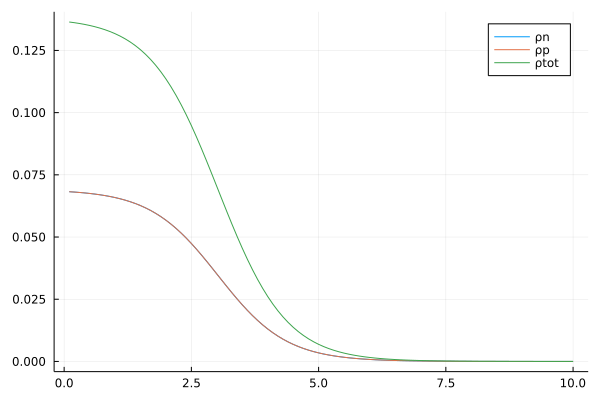

In [83]:
test_initial_density(param)

In [84]:
function calc_potential!(Vs, param, dens, qnum)
    @unpack M, t₀, x₀, t₃, x₃, α, rs = param 
    @unpack ρq, ρtot = dens
    @unpack l, q = qnum
    
    @views @. begin
        Vs  = t₀*((1+0.5x₀)*ρtot - (x₀+0.5)*ρq[:,q])
        
        Vs +=  1/12*t₃*(1+0.5x₃)*(α+2)*ρtot^(α+1)
        
        Vs += -1/12*t₃*(x₃+0.5)*α*(ρtot^(α-1))*
                    (ρq[:,1]*ρq[:,1]+ρq[:,2]*ρq[:,2])
        
        Vs += -1/12*t₃*(x₃+0.5)*(ρtot^α)*2ρq[:,q]
        
        Vs += M*l*(l+1)/rs^2
    end
end

function test_calc_potential(param; l=0)
    @unpack ħc, mc², rs, Nr = param 
    dens = initial_density(param)
    
    Vs = similar(rs)
    
    p = plot(; ylim=(-60, 10))
    
    qnum = My.QuantumNumbers(l=l, q=1)
    @time calc_potential!(Vs, param, dens, qnum)
    plot!(rs, Vs; label="V_n")
    
    qnum = My.QuantumNumbers(l=l, q=2)
    @time calc_potential!(Vs, param, dens, qnum)
    plot!(rs, Vs; label="V_p")
end

test_calc_potential (generic function with 1 method)

  0.000345 seconds
  0.000007 seconds


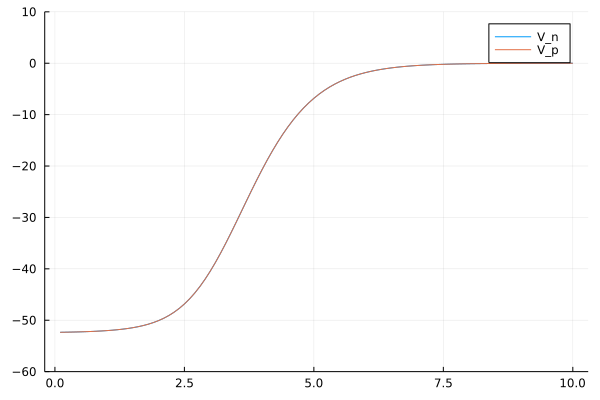

In [85]:
test_calc_potential(param)

In [65]:
function make_Hamiltonian!(param, Vs)
    @unpack M, Nr, Δr, rs, dv, ev = param
    
    @. dv = 2/Δr^2 + Vs/M
    @. ev = -1/Δr^2
    
    return SymTridiagonal(dv, ev)
end


function test_make_Hamiltonian(param; l=0)
    @unpack M, Nr, rs = param
    Vs = @. M*rs^2
    
    @time Hmat = make_Hamiltonian!(param, Vs)
    @time eigvals(Hmat)[1:10] ./2
end

test_make_Hamiltonian (generic function with 2 methods)

In [67]:
test_make_Hamiltonian(param)

  0.000003 seconds
  0.000250 seconds (6 allocations: 3.906 KiB)


10-element Vector{Float64}:
  1.4984357366699579
  3.49216962135222
  5.480870301381523
  7.464518486063689
  9.44309463646255
 11.416578960086351
 13.384951405415446
 15.348191656263882
 17.306279125969944
 19.259192951407556

In [129]:
function initial_states!(Vs, param, dens)
    @unpack M, Nr, Δr, rs, Emax, lmax, nstates_max = param
    
    spEs = zeros(Float64, nstates_max)
    qnums = Vector{My.QuantumNumbers}(undef, nstates_max)
    wfs = zeros(Float64, Nr, nstates_max)
    occ = zeros(Float64, nstates_max)
    
    istate = 0
    for l in 0:lmax, q in 1:2
        qnum = My.QuantumNumbers(l=l, q=q)
        calc_potential!(Vs, param, dens, qnum)
        Hmat = make_Hamiltonian!(param, Vs)
        
        vals, vecs = eigen(Hmat)
        
        # normalization
        @. vals *= M
        @. vecs /= sqrt(Δr)
        
        n = length(vals[vals .< Emax])
        @views for i in 1:n
            istate += 1
            wfs[:, istate] = vecs[:,i]
            spEs[istate] = vals[i]
            qnums[istate] = qnum
        end
    end
    
    states = My.SingleParticleStates(
        nstates=istate,
        spEs=spEs[1:istate], 
        qnums=qnums[1:istate], 
        wfs=wfs[:,1:istate], 
        occ=occ[1:istate])
    
    return states
end

function sort_states!(states)
    @unpack spEs, qnums, wfs = states
    p = sortperm(spEs)
    wfs[:] = wfs[:,p]
    spEs[:] = spEs[p]
    qnums[:] = qnums[p]
    return 
end

function calc_occ!(states, param)
    @unpack A, Z, N = param
    @unpack nstates, spEs, qnums, occ = states
    
    fill!(occ, 0)
    
    n_neutron = 0
    n_proton  = 0
    
    for i in 1:nstates
        if spEs[i] == 1e10
            break
        end
        
        @unpack l, q = qnums[i]
        
        if q === 1 # neutron
            if n_neutron + 2(2l+1) ≤ N
                occ[i] = 1
                n_neutron += 2(2l+1)
            elseif n_neutron < N
                occ[i] = (N - n_neutron)/2(2l+1)
            end
        end
        
        if q === 2 # proton
            if n_proton + 2(2l+1) ≤ Z
                occ[i] = 1
                n_proton += 2(2l+1)
            elseif n_proton < Z
                occ[i] = (Z - n_proton)/2(2l+1)
            end
        end
    end
    
    @assert n_neutron === N
    @assert n_proton  === Z
    
    return 
end

function show_states(states)
    @unpack nstates, spEs, qnums, occ = states
    for i in 1:nstates
        println("i = $i: ")
        @show spEs[i] qnums[i] occ[i]
        println("")
    end
end

function test_initial_states!(param)
    @unpack Nr, rs = param
    dens = initial_density(param)
    
    Vs = zeros(Float64, Nr)
    @time states = initial_states!(Vs, param, dens)
    @time sort_states!(states)
    @time calc_occ!(states, param)
    
    show_states(states)
end

test_initial_states! (generic function with 1 method)

In [132]:
test_initial_states!(param)

  0.011234 seconds (190 allocations: 2.052 MiB)
  0.000036 seconds (5 allocations: 8.594 KiB)
  0.000001 seconds
i = 1: 
spEs[i] = -37.54576204592733
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 2: 
spEs[i] = -37.54576204592733
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2

occ[i] = 1.0

i = 3: 
spEs[i] = -25.133125120743518
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 4: 
spEs[i] = -25.133125120743518
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2

occ[i] = 1.0

i = 5: 
spEs[i] = -11.858887016542143
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1

occ[i] = 0.0

i = 6: 
spEs[i] = -11.858887016542143
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2

occ[i] = 0.0

i = 7: 
spEs[i] = -10.547651208486768
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 0.0

i = 8: 

In [136]:
function first_deriv!(dψ, rs, ψ)
    Nr = length(rs)
    Δr = rs[2] - rs[1]
    
    dψ[1] = ψ[2]/2Δr
    for ir in 2:Nr-1
        dψ[ir] = (ψ[ir+1] - ψ[ir-1])/2Δr
    end
    dψ[Nr] = -ψ[Nr-1]/2Δr
    
    return 
end

function calc_density!(dens, param, states)
    @unpack rs, dψ = param
    @unpack nstates, qnums, wfs, occ = states
    @unpack ρq, τq, ρtot, τtot = dens
    
    fill!(ρq, 0)
    fill!(τq, 0)
    @views for i in 1:nstates
        if occ[i] ≈ 0
            break
        end
        @unpack l, q = qnums[i]
        
        ψ = wfs[:,i]
        first_deriv!(dψ, rs, ψ)
        
        @. ρq[:,q] += occ[i] * 2(2l+1)/4π * (ψ/rs)^2
        @. τq[:,q] += occ[i] * 2(2l+1)/4π * (dψ/rs - ψ/(rs*rs))*(dψ/rs - ψ/(rs*rs))
        @. τq[:,q] += occ[i] * 2(2l+1)/4π * l*(l+1)*(ψ/rs^2)^2
    end
    
    @views @. ρtot = ρq[:,1] + ρq[:,2]
    @views @. τtot = τq[:,1] + τq[:,2]
    
    return
end

function test_calc_density(param)
    @unpack rs, Nr = param
    
    p = plot()
    
    dens = initial_density(param)
    plot!(p, rs, dens.ρq[:,1]; label="ρ₀")
    
    Vs = zeros(Float64, Nr)
    
    states = initial_states!(Vs, param, dens)
    sort_states!(states)
    calc_occ!(states, param)
    
    @time calc_density!(dens, param, states)
    
    plot!(p, rs, dens.ρq[:,1]; label="ρ")
    plot!(p, rs, dens.τq[:,1]; label="τ")
    display(p)
    
end

test_calc_density (generic function with 1 method)

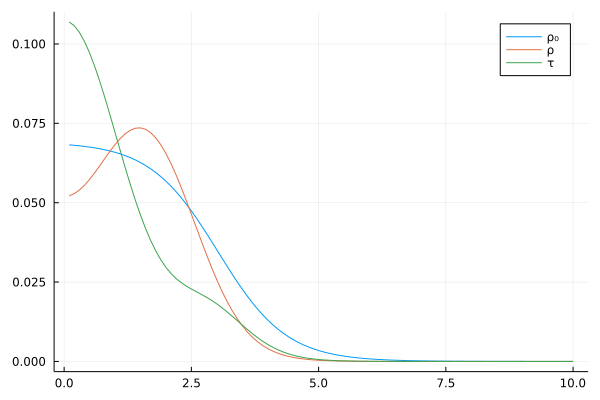

  0.000732 seconds


In [137]:
test_calc_density(param)

In [123]:
function calc_norm(param, ψ)
    @unpack Δr = param
    sqrt(dot(ψ, ψ)*Δr)
end

function calc_sp_energy(param, Hmat, ψ)
    @unpack M = param
    dot(ψ, Hmat, ψ)/dot(ψ, ψ) * M
end

function calc_total_energy(param, dens)
    @unpack M, t₀, x₀, t₃, x₃, α, Δr, Nr, rs = param 
    @unpack ρq, τq, ρtot, τtot = dens
    
    ε = zeros(Float64, Nr)
    @views begin
        @. ε += M*τtot

        @. ε += +0.5t₀*(1+0.5x₀)*ρtot*ρtot
        @. ε += -0.5t₀*(x₀+0.5)*(ρq[:,1]*ρq[:,1]+ρq[:,2]*ρq[:,2])
        
        @. ε += +1/12*t₃*(1+0.5x₃)*ρtot^(α+2)
        @. ε += -1/12*t₃*(x₃+0.5)*ρtot^α*
                    (ρq[:,1]*ρq[:,1]+ρq[:,2]*ρq[:,2])
    end
    
    return sum((@. 4π*rs^2 * ε)) * Δr
end

function calc_total_energy2(param, dens, states)
    @unpack M, t₀, t₃, α, Δr, Nr, rs = param 
    @unpack ρq, τq, ρtot, τtot = dens
    @unpack nstates, spEs, qnums, occ = states
    
    ε = zeros(Float64, Nr)
    @. ε += 0.5M*τtot
    @. ε += -α/32 * t₃ * ρ^(α+2)
    
    E = sum((@. 4π*rs^2*ε)) * Δr
    
    for i in 1:nstates
        @unpack l = qnums[i]
        E += occ[i] * 4(2l+1) * 0.5spEs[i]
    end
    
    return E
end

calc_total_energy2 (generic function with 1 method)

In [185]:
function gram_schmidt!(param, states)
    @unpack Δr = param
    @unpack nstates, qnums, wfs = states
    
    for i in 1:nstates
        for j in 1:i-1
            if qnums[i] !== qnums[j] continue end
            
            @views wfs[:,i] .-= wfs[:,j] .* (dot(wfs[:,j], wfs[:,i])*Δr)
        end
        @views wfs[:,i] ./= calc_norm(param, wfs[:,i])
    end
end

function HF_calc_with_imaginary_time(param; Δt=0.1, iter_max=20)
    @unpack Nr, Δr = param
    
    dens = initial_density(param)
    
    Vs = zeros(Float64, Nr)
    
    states = initial_states!(Vs, param, dens)
    sort_states!(states)
    calc_occ!(states, param)
    calc_density!(dens, param, states)
    
    @unpack nstates, spEs, qnums, wfs, occ = states
    
    @views @time for iter in 1:iter_max
        
        for i in 1:nstates
            calc_potential!(Vs, param, dens, qnums[i])
            Hmat = make_Hamiltonian!(param, Vs)
            
            #wfs[:,i] = (I - 0.5Δt*Hmat)*wfs[:,i]
            mul!(wfs[:,i], I - 0.5Δt*Hmat, wfs[:,i])
            #wfs[:,i] = (I + 0.5Δt*Hmat)\wfs[:,i]
            ldiv!(wfs[:,i], I + 0.5Δt*Hmat, wfs[:,i])
            
            for j in 1:i-1
                if qnums[i] !== qnums[j] continue end

                wfs[:,i] .-= wfs[:,j] .* (dot(wfs[:,j], wfs[:,i])*Δr)
            end
            wfs[:,i] ./= calc_norm(param, wfs[:,i])
            spEs[i] = calc_sp_energy(param, Hmat, wfs[:,i])
        end
            
        sort_states!(states)
        calc_occ!(states, param)
        calc_density!(dens, param, states)
    end
    
    @show calc_total_energy(param, dens)
    #@show calc_total_energy2(param, dens, states)
    show_states(states)
    
    return dens, states
end
        
                

HF_calc_with_imaginary_time (generic function with 1 method)

In [194]:
param = My.PhysicalParam(N=8, Z=8, lmax=10, Emax=0.0)
HF_calc_with_imaginary_time(param; iter_max=20)
;

  0.002151 seconds (2.50 k allocations: 2.219 MiB)
calc_total_energy(param, dens) = -189.18201361251286
i = 1: 
spEs[i] = -36.03982375008472
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 2: 
spEs[i] = -36.03982375008472
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 2

occ[i] = 1.0

i = 3: 
spEs[i] = -20.90858637086101
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 1

occ[i] = 1.0

i = 4: 
spEs[i] = -20.90858637086101
qnums[i] = Main.My.QuantumNumbers
  l: Int64 1
  j: Int64 1
  q: Int64 2

occ[i] = 1.0

i = 5: 
spEs[i] = -4.004057898217935
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 1

occ[i] = 0.0

i = 6: 
spEs[i] = -4.004057898217935
qnums[i] = Main.My.QuantumNumbers
  l: Int64 2
  j: Int64 1
  q: Int64 2

occ[i] = 0.0

i = 7: 
spEs[i] = -1.6250110424778619
qnums[i] = Main.My.QuantumNumbers
  l: Int64 0
  j: Int64 1
  q: Int64 1

occ[i] = 0.0

i = 8: 
spEs[i] = -1